# Human-in-the-loopの例

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# --- 状態の定義 ---
class State(TypedDict):
    draft: str
    approved: bool
    step: str
    human_input: str

# --- ノード関数 ---
def generate_draft(state: State) -> State:
    state["draft"] = "AIが作成した提案書"
    state["step"] = "generated"
    print(f"下書き: {state['draft']}")
    return state

def review_draft(state: State) -> State:
    print("人間のレビュー待ち...")
    print("承認する場合は 'approve'、却下する場合は 'reject' を入力してください")
    state["step"] = "reviewing"
    return state

def process_human_input(state: State) -> State:
    human_input = state.get("human_input", "")
    if not human_input:
        print("人間の入力がありません")
        return state

    if human_input not in ("approve", "reject"):
        print("無効な入力です（'approve' または 'reject' のみ有効）")
        return state

    state["approved"] = (human_input == "approve")
    state["step"] = "reviewed"
    if state["approved"]:
        print("人間が承認しました")
    else:
        print("人間が却下しました")
    return state

def finalize(state: State) -> State:
    if state["approved"]:
        print("下書きが承認されました。最終化します。")
        state["step"] = "approved"
    else:
        print("下書きは却下されました。")
        state["step"] = "rejected"
    return state

# --- グラフ構築 ---
graph = StateGraph(State)
graph.add_node("generate", generate_draft)
graph.add_node("review", review_draft)
graph.add_node("process_input", process_human_input)
graph.add_node("finalize", finalize)

graph.set_entry_point("generate")
graph.add_edge("generate", "review")
graph.add_edge("review", "process_input")
graph.add_edge("process_input", "finalize")
graph.add_edge("finalize", END)

# チェックポイントを有効化（process_inputノードの前で中断）
app = graph.compile(checkpointer=MemorySaver(), interrupt_before=["process_input"])

def run_workflow(thread_id: str = "notebook-1"):
    """
    1. 生成 → レビュー直前で中断
    2. ユーザーの入力で 'approve' または 'reject' を受け取る
    3. state を update して invoke(None, config) で再開
    """
    config = {"configurable": {"thread_id": thread_id}}

    print("\n=== 実行（人間の入力待ちで中断） ===")
    result = app.invoke({"draft": "", "approved": False, "step": "init", "human_input": ""}, config)
    print(f"中断時の状態: {result}")

    # reviewing 状態でのみ入力受付
    if result.get("step") == "reviewing":
        # approve/reject のみを許可
        while True:
            answer = input("承認する場合は 'approve'、却下は 'reject' を入力してください: ").strip()
            if answer in ("approve", "reject"):
                app.update_state(config, {"human_input": answer})
                break
            print("入力が無効です。'approve' または 'reject' を入力してください。")

        print("\n=== 再開 ===")
        final_result = app.invoke(None, config)
        print(f"最終状態: {final_result}")
        return final_result
    else:
        print("中断ポイントに到達しませんでした。")
        return result

# --- 実行例 ---
run_workflow("notebook-1")



=== 実行（人間の入力待ちで中断） ===
下書き: AIが作成した提案書
人間のレビュー待ち...
承認する場合は 'approve'、却下する場合は 'reject' を入力してください
中断時の状態: {'draft': 'AIが作成した提案書', 'approved': False, 'step': 'reviewing', 'human_input': ''}


承認する場合は 'approve'、却下は 'reject' を入力してください:  approve



=== 再開 ===
人間が承認しました
下書きが承認されました。最終化します。
最終状態: {'draft': 'AIが作成した提案書', 'approved': True, 'step': 'approved', 'human_input': 'approve'}


{'draft': 'AIが作成した提案書',
 'approved': True,
 'step': 'approved',
 'human_input': 'approve'}

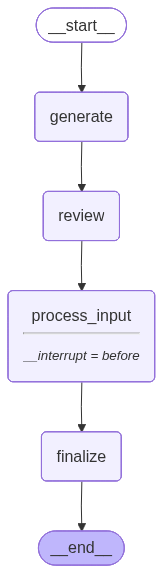

In [ ]:
from IPython.display import Image
# コンパイル済みグラフから図を生成して表示
Image(app.get_graph().draw_mermaid_png())